# Outlier Detection
> Comparison Study

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

ref: https://scikit-learn.org/stable/modules/outlier_detection.html

**Inliers are labeled 1, while outliers are labeled -1**

In [884]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

## EbayesThresh

In [719]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [720]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [721]:
%R -o x 

In [722]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [723]:
xhat = np.array(ebayesthresh(FloatVector(x)))

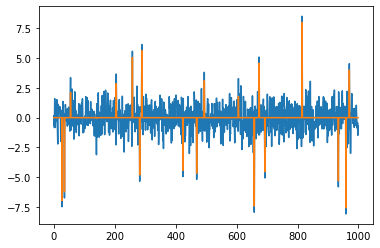

In [724]:
plt.plot(x)
plt.plot(xhat)

In [725]:
outlier_true_index = np.where(xhat!=0)

In [726]:
outlier_true_index

(array([ 27,  35,  55, 140, 205, 258, 282, 289, 424, 469, 494, 606, 658,
        674, 693, 815, 934, 959, 970]),)

In [727]:
outlier_true_value = xhat[xhat!=0]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [728]:
outlier_true_one = xhat

In [729]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## sklearn.neighbors.LocalOutlierFactor

### 1. linear

In [932]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [933]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [934]:
_df1=pd.DataFrame({'x':_x, 'y':_y})

---

In [935]:
X = np.array(_df)

In [936]:
clf = LocalOutlierFactor(n_neighbors=2)

In [937]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1

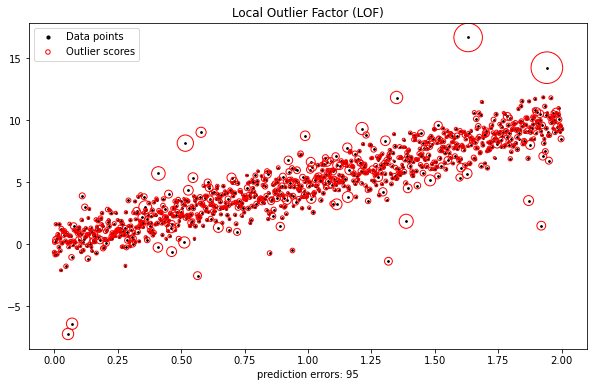

In [938]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [735]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [736]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [737]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [738]:
w=np.zeros((1000,1000))

In [739]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [740]:
_simul = SIMUL(_df)

In [741]:
_simul.fit()

In [742]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [743]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [744]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [745]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

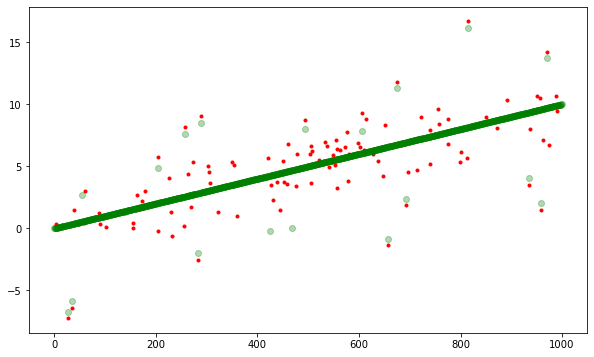

In [748]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

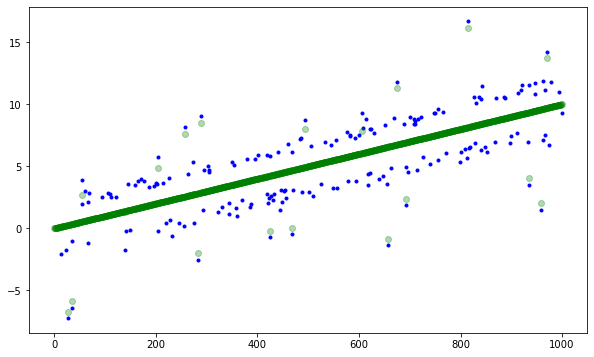

In [750]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [751]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 106, 180)

In [752]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 15 개 detecting


In [753]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7894736842105263

In [754]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [755]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [756]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

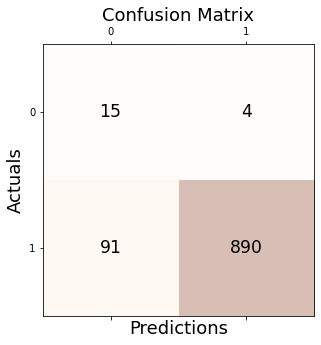

In [757]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [758]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7894736842105263

In [759]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.905
Precision: 0.996
Recall: 0.907
F1 Score: 0.949


In [760]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

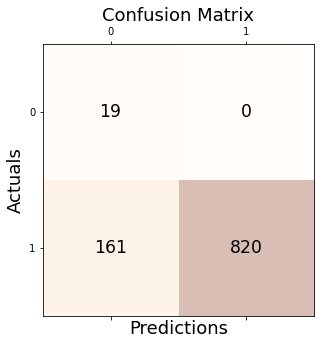

In [761]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [762]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [763]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.839
Precision: 1.000
Recall: 0.836
F1 Score: 0.911


### 2. linear(2)

In [939]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [940]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [941]:
_df2=pd.DataFrame({'x':_x, 'y':_y})

---

In [942]:
X = np.array(_df)

In [943]:
clf = LocalOutlierFactor(n_neighbors=2)

In [944]:
clf.fit_predict(X)

array([-1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

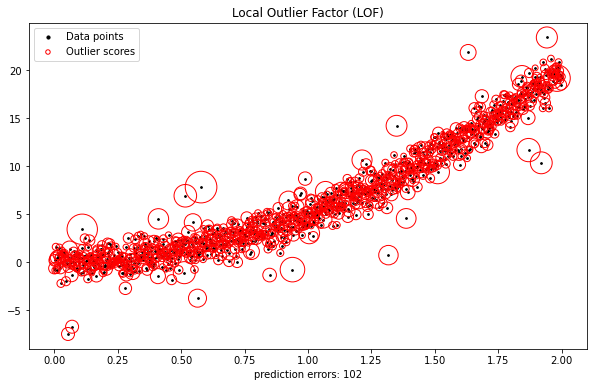

In [945]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [946]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [522]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [523]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [524]:
w=np.zeros((1000,1000))

In [525]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [526]:
_simul = SIMUL(_df)

In [527]:
_simul.fit()

In [528]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [529]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [530]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [531]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

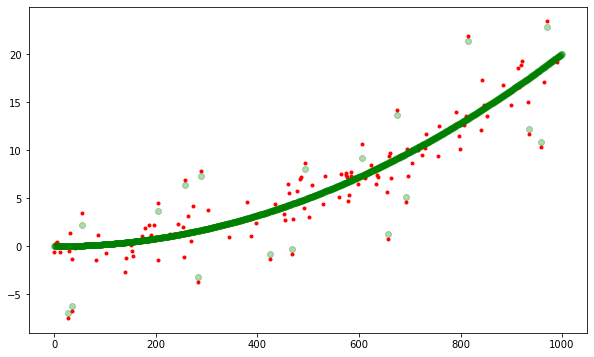

In [532]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

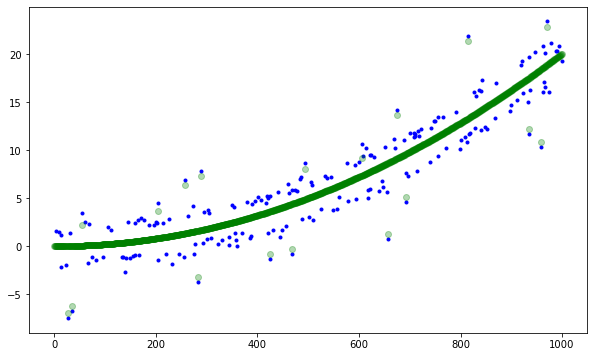

In [533]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [534]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 121, 191)

In [535]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [536]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [537]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [538]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [539]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

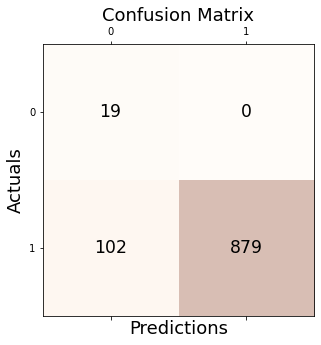

In [540]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [541]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [542]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.898
Precision: 1.000
Recall: 0.896
F1 Score: 0.945


In [543]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

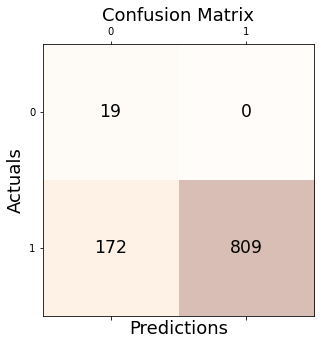

In [544]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [545]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [546]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.828
Precision: 1.000
Recall: 0.825
F1 Score: 0.904


### 3. sin

In [947]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [948]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [949]:
_df3=pd.DataFrame({'x':_x, 'y':_y})

---

In [950]:
X = np.array(_df)

In [951]:
clf = LocalOutlierFactor(n_neighbors=2)

In [952]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

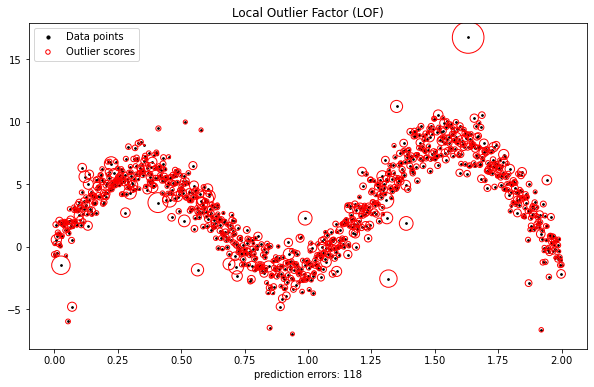

In [953]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [954]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [955]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [559]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [560]:
w=np.zeros((1000,1000))

In [561]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [562]:
_simul = SIMUL(_df)

In [563]:
_simul.fit()

In [564]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [565]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [566]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [567]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

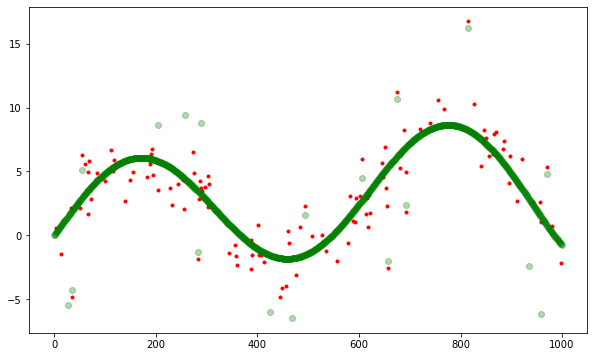

In [568]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

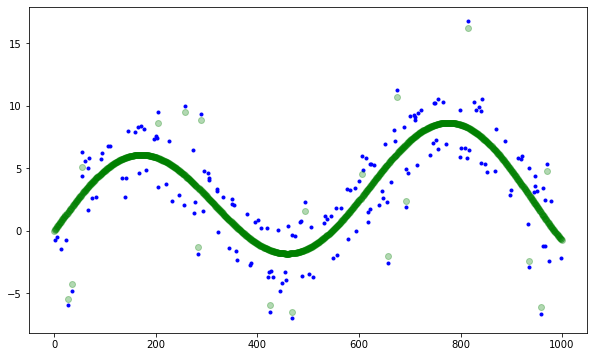

In [569]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [570]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 121, 179)

In [571]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 11 개 detecting


In [572]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.5789473684210527

In [573]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [574]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [575]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

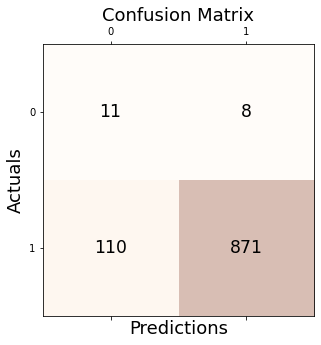

In [576]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [577]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.5789473684210527

In [578]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.882
Precision: 0.991
Recall: 0.888
F1 Score: 0.937


In [579]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

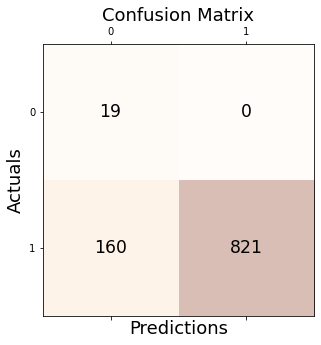

In [580]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [581]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [582]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.840
Precision: 1.000
Recall: 0.837
F1 Score: 0.911


### 4. cosin

In [956]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [957]:
_df=pd.DataFrame({'x':_x, 'y':_y})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [958]:
_df4=pd.DataFrame({'x':_x, 'y':_y})

---

In [959]:
X = np.array(_df)

In [960]:
clf = LocalOutlierFactor(n_neighbors=2)

In [961]:
clf.fit_predict(X)

array([ 1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1,  1, -1,  1,  1

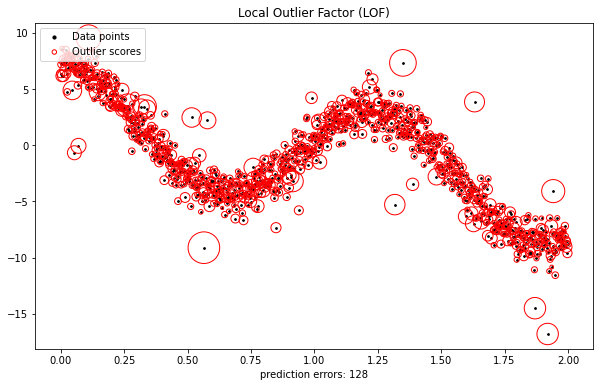

In [962]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [588]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [589]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [590]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [591]:
w=np.zeros((1000,1000))

In [592]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [593]:
_simul = SIMUL(_df)

In [594]:
_simul.fit()

In [595]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [596]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [597]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [598]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

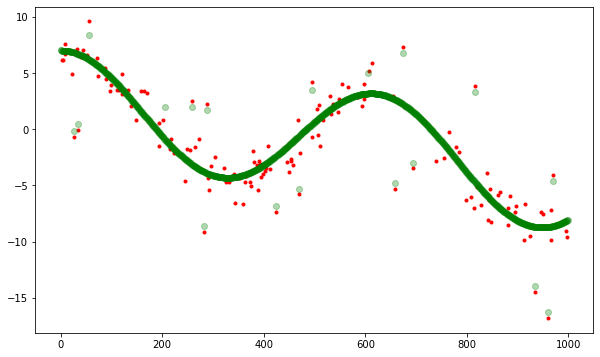

In [599]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+xhat,'go',alpha=0.3)

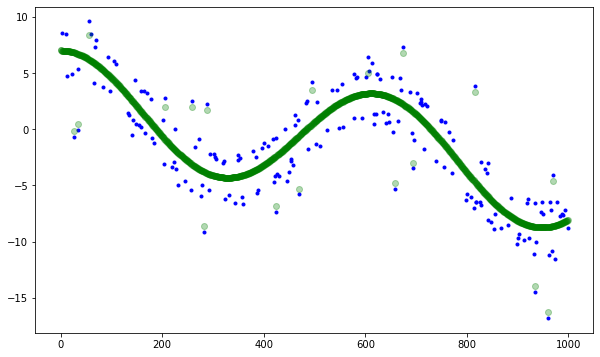

In [600]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+xhat,'go',alpha=0.3)

In [601]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 141, 194)

In [602]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 16 개 detecting


In [603]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.8421052631578947

In [604]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [605]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [606]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

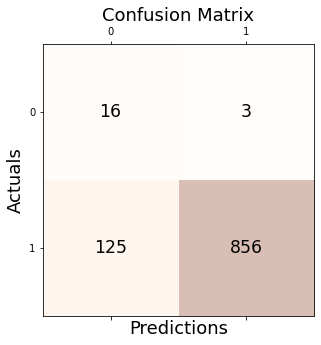

In [607]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [608]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.8421052631578947

In [609]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.872
Precision: 0.997
Recall: 0.873
F1 Score: 0.930


In [610]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

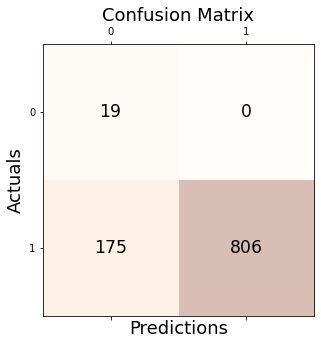

In [611]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [612]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [613]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.825
Precision: 1.000
Recall: 0.822
F1 Score: 0.902


### 5. One dimensional manifold

In [963]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [964]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [965]:
_df5=pd.DataFrame({'x':_x, 'y':_y, 'f':f})

---

In [966]:
X = np.array(_df)

In [967]:
clf = LocalOutlierFactor(n_neighbors=2)

In [968]:
clf.fit_predict(X)

array([ 1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1

<Figure size 720x432 with 0 Axes>

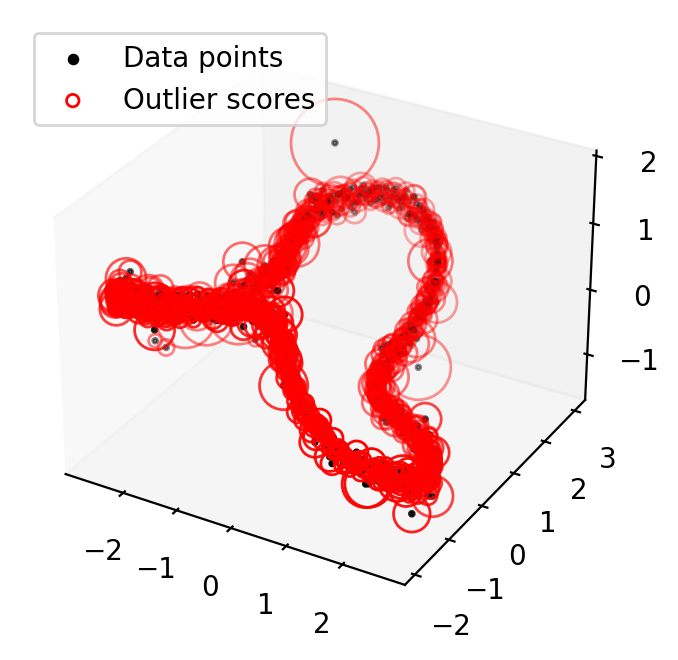

In [979]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

outlier

In [619]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [620]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [621]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [622]:
_simul = SIMUL(_df)

In [623]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 554.00it/s]


In [624]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [625]:
_simul.fit()

In [626]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [627]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [628]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [629]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [630]:
len(outlier_true_value),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(19, 129, 205)

In [631]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_first_index)),"개 detecting")

19 개 outlier 중에 14 개 detecting


In [632]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7368421052631579

In [633]:
print(len(outlier_true_value),"개 outlier 중에",len(np.intersect1d(outlier_true_index,outlier_simul_first_index)),"개 detecting")

19 개 outlier 중에 19 개 detecting


In [634]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

In [635]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=vx,
#     y=vy,
#     z=f,
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=f,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.2
#     )
# )])
# fig.add_scatter3d(x=_df.loc[outlier_first_index]['x'],y=_df.loc[outlier_first_index]['y'],z=_df.loc[outlier_first_index]['f'], mode="markers",marker=dict(size=3, color="blue"),name='f',opacity=0.5)
# fig.add_trace(go.Scatter3d(x=vx,y=vy,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(xaxis = dict(range=[-3,3],),
#                                          yaxis = dict(range=[-3,3],),
#                                          zaxis = dict(range=[-10,10],),),width=800,height=800,autosize=False)
# fig.show()

In [636]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=vx,
#     y=vy,
#     z=f,
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=f,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.2
#     )
# )])
# fig.add_scatter3d(x=_simul.df.loc[outlier_simul_first_index]['x'],y=_simul.df.loc[outlier_simul_first_index]['y'],z=_simul.df.loc[outlier_simul_first_index]['f'], mode="markers",marker=dict(size=3, color="red"),name='f',opacity=0.5)
# fig.add_trace(go.Scatter3d(x=vx,y=vy,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene = dict(xaxis = dict(range=[-3,3],),
#                                          yaxis = dict(range=[-3,3],),
#                                          zaxis = dict(range=[-10,10],),),width=800,height=800,autosize=False)
# fig.show()

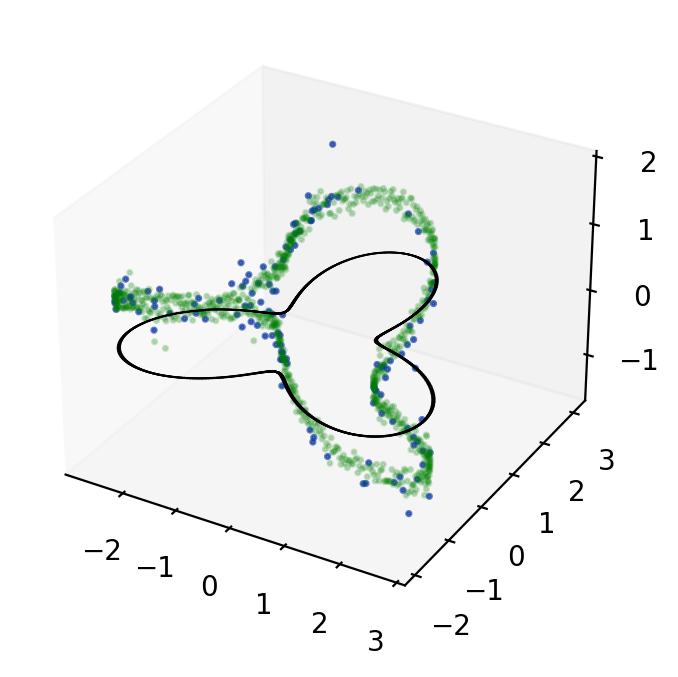

In [637]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_df.loc[outlier_first_index]['x'],_df.loc[outlier_first_index]['y'],_df.loc[outlier_first_index]['f'], zdir='z',s=10,marker='.',c='blue',alpha=0.5)
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

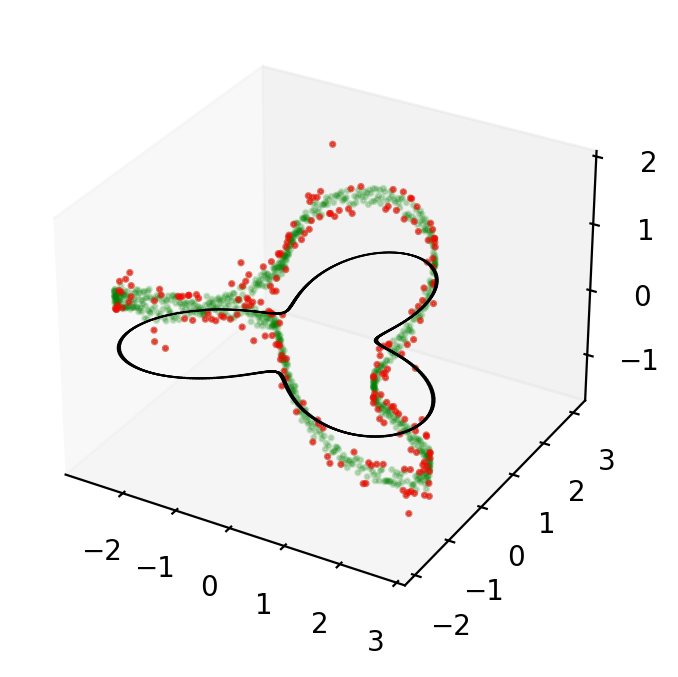

In [638]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_simul.df.loc[outlier_simul_first_index]['x'],_simul.df.loc[outlier_simul_first_index]['y'],_simul.df.loc[outlier_simul_first_index]['f'], zdir='z',s=10,marker='.',c='red',alpha=0.5)
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

In [639]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

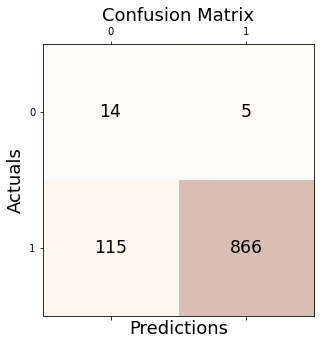

In [640]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [641]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7368421052631579

In [642]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.880
Precision: 0.994
Recall: 0.883
F1 Score: 0.935


In [643]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

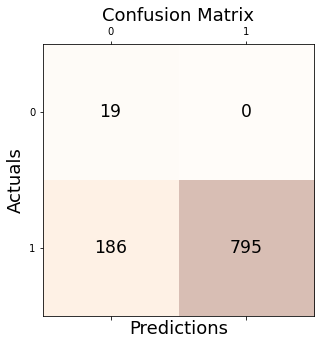

In [644]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [645]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

1.0

In [646]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.814
Precision: 1.000
Recall: 0.810
F1 Score: 0.895


### 6. Bunny(Two dimensional manifold)

In [1001]:
G = graphs.Bunny()
n = G.N

In [1002]:
g = filters.Heat(G, tau=75) 

In [1003]:
np.random.seed(1)
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [1004]:
outlier_true_index_2 = np.where(noise>1)

In [1005]:
outlier_true_value_2 = noise[noise>1]

In [1006]:
outlier_true_one_2 = noise

In [1007]:
outlier_true_one_2 = list(map(lambda x: -1 if x > 1 else 1,outlier_true_one_2))

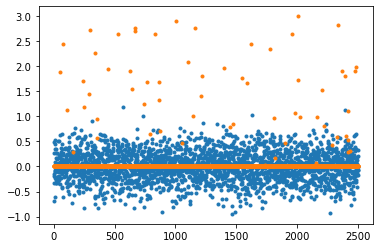

In [1008]:
plt.plot(normal,'.')
plt.plot(unif,'.')
#plt.plot(noise,'--')

In [1009]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-01 22:28:25,724:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [1010]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [1011]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f, 'noise' : noise})

---

그래프를 위한 데이터(_df) 그래프 (robust covari)

In [1012]:
_df6=pd.DataFrame({'x':_x, 'y':_y,'z' : _z, 'f' : f, 'noise' : noise})

---

In [1013]:
X = np.array(_df)

In [1014]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1015]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

<Figure size 720x432 with 0 Axes>

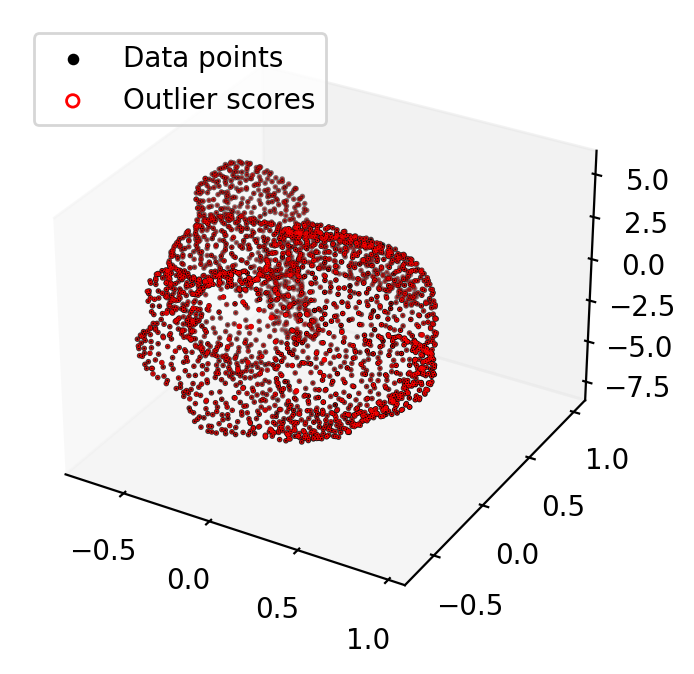

In [1023]:
ground_truth=outlier_true_one_2
y_pred = clf.fit_predict(X[:,:4])
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=1.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

outlier

In [661]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [662]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [663]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [664]:
_simul = SIMUL(_df)

In [665]:
_simul.fit()

In [666]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [667]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [668]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [669]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

In [670]:
len(outlier_true_value_2),len(outlier_first_value),len(_simul.df.query('Residual**2>2'))

(43, 33, 32)

In [671]:
print(len(outlier_true_value_2),"개 outlier 중에",len(np.intersect1d(outlier_true_index_2,outlier_first_index)),"개 detecting")

43 개 outlier 중에 0 개 detecting


In [672]:
len(np.intersect1d(outlier_true_index_2,outlier_first_index))/len(np.array(outlier_true_index_2).tolist()[0])

0.0

In [673]:
print(len(outlier_true_value_2),"개 outlier 중에",len(np.intersect1d(outlier_true_index_2,outlier_simul_first_index)),"개 detecting")

43 개 outlier 중에 31 개 detecting


In [674]:
len(np.intersect1d(outlier_true_index_2,outlier_simul_first_index))/len(np.array(outlier_true_index_2).tolist()[0])

0.7209302325581395

In [718]:
# fig = px.scatter_3d(x=_simul.df.query('Residual**2>6')['x'],y=_simul.df.query('Residual**2>6')['y'],z=_simul.df.query('Residual**2>6')['z'],
#                     color=_simul.df.query('Residual**2>6')['fnoise'],
#                     opacity=1,
#                     height=400,
#                     size=abs(_simul.df.query('Residual**2>6')['fnoise']),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))

In [675]:
conf_matrix = confusion_matrix(outlier_true_one_2, clf.fit_predict(X[:,:4]))

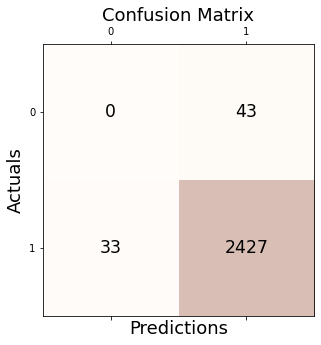

In [676]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [677]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.0

In [679]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Precision: %.3f' % precision_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Recall: %.3f' % recall_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))

Accuracy: 0.970
Precision: 0.983
Recall: 0.987
F1 Score: 0.985


In [680]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_simul_one)

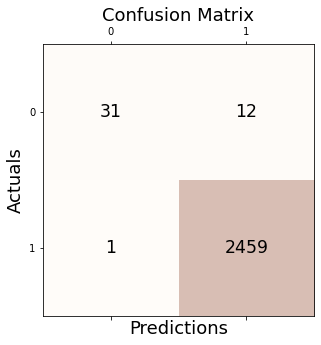

In [681]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [682]:
conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

0.7209302325581395

In [683]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_simul_one))

Accuracy: 0.995
Precision: 0.995
Recall: 1.000
F1 Score: 0.997


---

## Robust covariance estimation and Mahalanobis distances relevance

### 1.

In [809]:
X = np.array(_df1)

In [810]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [811]:
outlier_true_index = np.where(xhat!=0)

In [812]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [813]:
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[0.33374675 1.66493964]
 [1.66493964 9.0457317 ]]
MLE:
[[0.38557293 1.63528804]
 [1.63528804 9.88099651]]


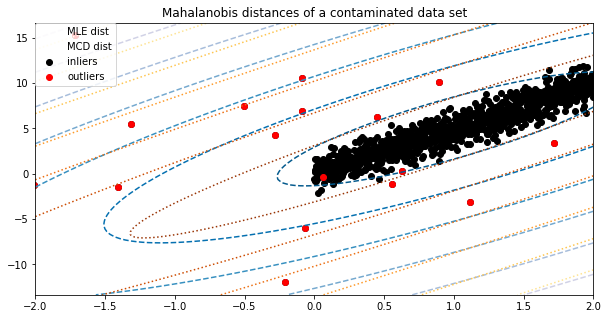

In [815]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()


### 2.

In [803]:
X = np.array(_df2)

In [804]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [805]:
outlier_true_index = np.where(xhat!=0)

In [806]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [807]:
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[ 0.22421142  1.76689791]
 [ 1.76689791 15.77986845]]
MLE:
[[ 0.37275859  3.35235787]
 [ 3.35235787 37.0057974 ]]


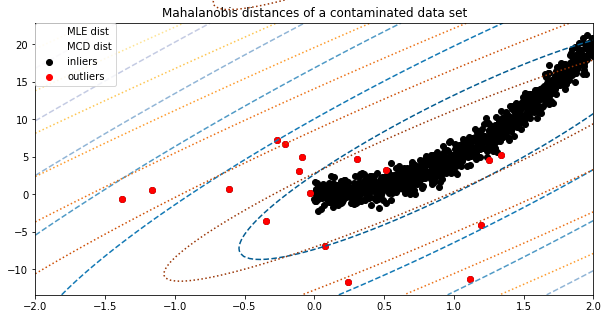

In [808]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()


### 3.

In [816]:
X = np.array(_df3)

In [817]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [818]:
outlier_true_index = np.where(xhat!=0)

In [819]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [820]:
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[ 0.14851074 -0.49349638]
 [-0.49349638  8.37450123]]
MLE:
[[ 0.3477353   0.40788154]
 [ 0.40788154 12.17587447]]


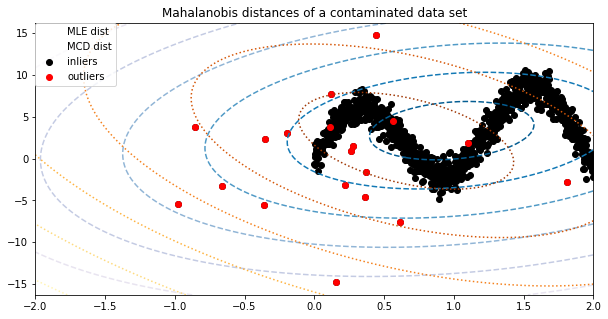

In [821]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()


### 4.

In [822]:
X = np.array(_df4)

In [823]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [824]:
outlier_true_index = np.where(xhat!=0)

In [825]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [826]:
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[0.16748272 0.35641855]
 [0.35641855 7.96160937]]
MLE:
[[ 0.35228133 -1.56876127]
 [-1.56876127 20.53999811]]


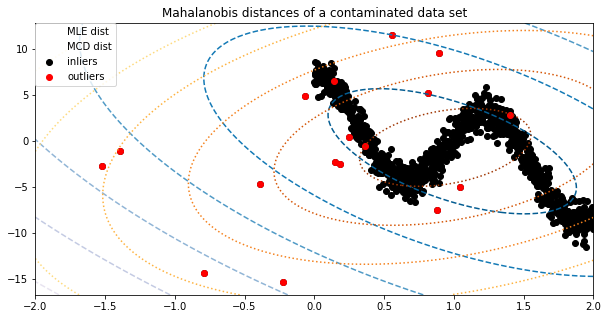

In [827]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()
